True

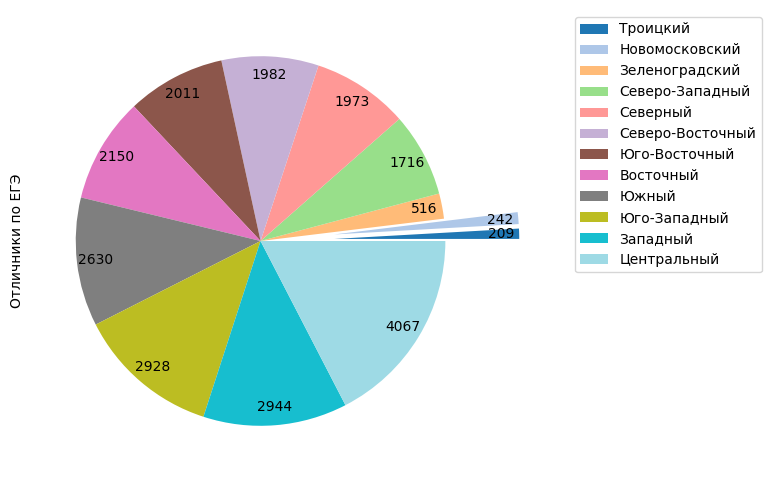

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import pdfkit
from io import BytesIO
import binascii
import smtplib
from email import encoders
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart

#подключаем необходимые библиотеки и модули, загружаем данные (через делитель «;»)
data = pd.read_csv("https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv", delimiter=";")
# выделим результаты 2018-2019 годов
data = data[data["YEAR"] == "2018-2019"]
# выполним все преобразования данных
#Находим лучшую школу по результатам ЕГЭ
data_best = data.sort_values("PASSES_OVER_220", ascending=False).head(1)
#Выполним группировку по АО, уберем в названии все слова, кроме первого
data["AdmArea"] = data["AdmArea"].apply(lambda x: x.split(" ")[0])

data_adm = data.groupby("AdmArea").sum()["PASSES_OVER_220"].sort_values()
total = data_adm.sum()
#создадим холст на котором создадим список секторов и меру их выноса из основной диаграммы
fig = plt.figure(figsize=(11,6))
area = fig.add_subplot(1,1,1)
explode = [0]*len(data_adm)
explode[0] = 0.4
explode[1] = 0.4
#создадим круговую диаграмму с подписями
data_adm.plot.pie(ax = area,
                 labels=[""]*len(data_adm),
                 label="Отличники по ЕГЭ",
                 cmap="tab20",
                 autopct=lambda x:int(round(total * x/100)),
                 pctdistance=0.9,
                 explode=explode)
#справа выведем легенду с подписями секторов
plt.legend(data_adm.index, bbox_to_anchor=(1.5,1,0.1,0))
#создадим объект памяти и сохраним его
img = BytesIO()
plt.savefig(img)
#Для вставки изображения в отчет преобразуем его base64 кодировку
img = 'data:image/png;base64,' + binascii.b2a_base64(img.getvalue(),
                            newline=False).decode("UTF-8")
#Для корректного отображения длинного названия школы зададим настройку Пандос по длине в колонке
pd.set_option("display.max_colwidth", 1000)

#сформируем html-отчет со всеми данными
html = '''<html>
<head>
    <title>Результаты ЕГЭ Москвы: отличники</title>
    <meta charset="utf-8"/>
</head>
<body>
    <h1>Результаты ЕГЭ Москвы: отличники в 2018-2019 году</h1>
    <p>Всего: ''' + str(total) + '''</p>
    <img src="''' + img + '''" alt="Отличники по округам"/>
    <p>Лучшая школа: ''' + str(data_best["EDU_NAME"].values[0]) + '''</p>
</body>
</html>'''
#Сформируем pdf-отчет с необходимыми настройками 
config = pdfkit.configuration(wkhtmltopdf="C:/Program Files/wkhtmltopdf/bin/wkhtmltopdf.exe")
options = {
    'page-size': 'A4',
    'header-right': '[page]'
}
#Сохраним документ 'ege.best.pdf'
pdfkit.from_string(html, 'ege.best.pdf',
                   configuration=config, options=options)


In [12]:
# данные почтового сервиса
letter = MIMEMultipart()
letter["From"] = "perov-17@yandex.ru"
letter["Subject"] = "Результаты по ЕГЭ в Москве"
letter["Content-Type"] = "text/html; charset=utf-8"
letter["To"] = "perov-17@mail.ru"
letter.attach(MIMEText(html, "html"))
attachement = MIMEBase("application", "pdf")
attachement.set_payload(open("ege.best.pdf", "rb").read())
attachement.add_header("Content-Disposition",
                      'attachement; filename="ege.best.pdf"')
encoders.encode_base64(attachement)
letter.attach(attachement)

user = "perov-17@yandex.ru"
password = "XXXXXXXXXXXX"
server = smtplib.SMTP_SSL("smtp.yandex.ru", 465)
server.login(user, password)
server.sendmail("perov-17@yandex.com",
               "perov-17@mail.ru",
               letter.as_string())
#закроем почтовый сервер
server.quit()



(221, b'2.0.0 Closing connecton')